In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# ---- 시계열 딥러닝 모델 평가 통합 함수 ----
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, Flatten, Input, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


# ---- 머신러닝 모델 평가 통합 함수 ----
def ml_models_compare(
    X, y,
    models=('rf', 'xgb', 'lgbm', 'plsr', 'lr'),
    scaling='standard',
    test_size=0.2,
    random_state=42,
    model_params=None,
    plot=True,
):
    if model_params is None: model_params = {}
    results = []
    # scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = None
    if scaling == 'standard':
        scaler = StandardScaler()
    elif scaling == 'minmax':
        scaler = MinMaxScaler()
    if scaler:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
    for mtype in models:
        if mtype == 'rf':
            model = RandomForestRegressor(n_estimators=10000, random_state=random_state, **model_params.get('rf', {}))
        elif mtype == 'xgb':
            model = xgb.XGBRegressor(n_estimators=10000, random_state=random_state, **model_params.get('xgb', {}))
        elif mtype == 'lgbm':
            model = lgb.LGBMRegressor(n_estimators=10000, random_state=random_state, **model_params.get('lgbm', {}))
        elif mtype == 'plsr':
            model = PLSRegression(n_components=min(5, X_train.shape[1]), **model_params.get('plsr', {}))
        elif mtype == 'lr':
            model = LinearRegression()
        else:
            raise ValueError(mtype)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({'model': mtype, 'rmse': rmse, 'r2': r2, 'mae': mae})
        # Optional: plot 예측치
        if plot:
            plt.figure()
            plt.scatter(y_test, y_pred, alpha=0.7)
            minmax = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
            plt.plot(minmax, minmax, 'k--', lw=2, label='Ideal (y=x)')
            m, b = np.polyfit(y_test, y_pred, 1)
            plt.plot(minmax, [m*x+b for x in minmax], 'r-', lw=2, label='Best fit')
            # 메트릭스 표시
            txt = f'R2 = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}'
            plt.gca().text(0.02, 0.95, txt, transform=plt.gca().transAxes,
                   fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            plt.xlabel('True')
            plt.ylabel('Pred')
            plt.title(f'{mtype.upper()} Prediction')
            plt.grid(True)
            plt.show()
    result_df = pd.DataFrame(results)
    return result_df
# ---- 머신러닝 Feature Importance 분석 함수 ----
def ml_models_performance_curve(
    X, y, 
    model_type='rf',      # 'rf', 'xgb', 'lgbm', 'plsr', 'lr' 등
    test_size=0.2,
    random_state=42,
    max_num_features=None,
    plot=True,
    scaling=None,         # None, 'standard', 'minmax'
    model_params=None
):
    assert model_type in ['rf', 'xgb', 'lgbm', 'plsr', 'lr'], "model_type invalid"
    if model_params is None: model_params = {}
    # 스케일링
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    scaler = None
    if scaling is not None:
        if scaling == "standard": scaler = StandardScaler()
        elif scaling == "minmax": scaler = MinMaxScaler()
        else: raise ValueError("scaling: None/'standard'/'minmax'")
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    # 피처 선택용 모델
    if model_type == 'rf':
        model_default = RandomForestRegressor(n_estimators=300, random_state=random_state, **model_params)
        model_importance = lambda m: m.feature_importances_
    elif model_type == 'xgb':
        model_default = xgb.XGBRegressor(n_estimators=300, random_state=random_state, **model_params)
        model_importance = lambda m: m.feature_importances_
    elif model_type == 'lgbm':
        model_default = lgb.LGBMRegressor(n_estimators=300, random_state=random_state, **model_params)
        model_importance = lambda m: m.feature_importances_
    elif model_type == 'plsr':
        # PLSR은 feature importance 값이 없음(아래 feature importance는 생략)
        model_default = PLSRegression(n_components=min(X.shape[1], 5), **model_params)
        model_importance = lambda m: np.zeros(X.shape[1])
    elif model_type == 'lr':
        model_default = LinearRegression()
        model_importance = lambda m: np.abs(m.coef_)
    # 피처 임포턴스 기반 정렬
    model_default.fit(X_train, y_train)
    importances = model_importance(model_default)
    feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
    # feature 개수별 성능 곡선
    if max_num_features is None: max_num_features = len(X.columns)
    rmse_results, r2_results = [], []
    num_features_list = list(range(1, max_num_features+1))
    for n_features in num_features_list:
        top_features = feature_importance_df['feature'].iloc[:n_features].tolist()
        X_train_sub, X_test_sub = X_train[top_features], X_test[top_features]
        if model_type == 'rf':
            model = RandomForestRegressor(n_estimators=300, random_state=random_state, **model_params)
        elif model_type == 'xgb':
            model = xgb.XGBRegressor(n_estimators=300, random_state=random_state, **model_params)
        elif model_type == 'lgbm':
            model = lgb.LGBMRegressor(n_estimators=300, random_state=random_state, **model_params)
        elif model_type == 'plsr':
            model = PLSRegression(n_components=min(n_features,5), **model_params)
        elif model_type == 'lr':
            model = LinearRegression()
        model.fit(X_train_sub, y_train)
        y_pred = model.predict(X_test_sub)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        rmse_results.append(rmse)
        r2_results.append(r2)
    # 결과 데이터 프레임
    result_df = pd.DataFrame({
        'num_features': num_features_list,
        'RMSE': rmse_results,
        'R2': r2_results
    })
    # Plot
    if plot:
        fig, ax1 = plt.subplots(figsize=(8, 5))
        color1, color2 = 'tab:blue', 'tab:red'
        ax1.set_xlabel('Number of Features (top-N-selected)')
        ax1.set_ylabel('RMSE', color=color1)
        ax1.plot(num_features_list, rmse_results, marker='o', color=color1, label='RMSE')
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.invert_xaxis()
        ax2 = ax1.twinx()
        ax2.set_ylabel('R2 Score', color=color2)
        ax2.plot(num_features_list, r2_results, marker='s', color=color2, label='R2 Score')
        ax2.tick_params(axis='y', labelcolor=color2)
        fig.suptitle(f'Model Performance vs. Number of Features ({model_type.upper()})')
        fig.tight_layout()
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.show()
        if np.any(feature_importance_df['importance'] != 0):
            plt.figure(figsize=(8,5))
            top_show = min(20, len(feature_importance_df))
            plt.barh(feature_importance_df['feature'][:top_show], feature_importance_df['importance'][:top_show], color='skyblue')
            plt.xlabel('Feature Importance')
            plt.title(f'Top {top_show} Feature Importances ({model_type.upper()})')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
    return result_df, feature_importance_df
# ---- 시계열 딥러닝 모델 평가 함수 ----
def dl_seq_train(
    X_seq, y_seq,
    model_type='lstm',
    n_units=32,
    epochs=20,
    batch_size=32,
    test_size=0.2,
    random_state=42,
    scaling='standard',
    plot=True
):
    # scaling
    scaler = None
    if scaling:
        flatX = X_seq.reshape(-1, X_seq.shape[-1])
        if scaling == 'standard':
            scaler = StandardScaler()
        elif scaling == 'minmax':
            scaler = MinMaxScaler()
        scaler.fit(flatX)
        X_seq = scaler.transform(flatX).reshape(X_seq.shape)
    # data split
    np.random.seed(random_state)
    idx = np.arange(len(X_seq))
    np.random.shuffle(idx)
    n_train = int(len(idx)*(1-test_size))
    train_idx, test_idx = idx[:n_train], idx[n_train:]
    X_train, y_train = X_seq[train_idx], y_seq[train_idx]
    X_test, y_test = X_seq[test_idx], y_seq[test_idx]
    T, D = X_seq.shape[1], X_seq.shape[2]
    # Model build
    if model_type == 'mlp':
        model = Sequential([
            Flatten(input_shape=(T, D)),
            Dense(n_units, activation='relu'),
            Dropout(0.1),
            Dense(n_units, activation='relu'),
            Dense(1)
        ])
    elif model_type == 'cnn':
        model = Sequential([
            Conv1D(32, 5, activation='relu', input_shape=(T, D)),
            BatchNormalization(),
            Conv1D(16, 3, activation='relu'),
            GlobalAveragePooling1D(),
            Dense(n_units, activation='relu'),
            Dense(1)
        ])
    elif model_type == 'lstm':
        model = Sequential([
            LSTM(n_units, input_shape=(T, D)),
            Dense(1)
        ])
    elif model_type == 'gru':
        model = Sequential([
            GRU(n_units, input_shape=(T, D)),
            Dense(1)
        ])
    elif model_type == 'cnn_lstm':
        model = Sequential([
            Conv1D(32, 5, activation='relu', input_shape=(T, D)),
            BatchNormalization(),
            Conv1D(16, 3, activation='relu'),
            LSTM(n_units),
            Dense(1)
        ])
    else:
        raise ValueError(model_type)
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.15)
    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    if plot:
        plt.figure()
        plt.scatter(y_test, y_pred, alpha=0.7)
        minmax = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
        plt.plot(minmax, minmax, 'k--', lw=2, label='Ideal (y=x)')
        m, b = np.polyfit(y_test, y_pred, 1)
        plt.plot(minmax, [m*x+b for x in minmax], 'r-', lw=2, label='Best fit')
        # 메트릭스 표시
        txt = f'R2 = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}'
        plt.gca().text(0.02, 0.95, txt, transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", alpha=0.7))
        plt.xlabel('True')
        plt.ylabel('Pred')
        plt.title(f'{model_type.upper()} Prediction')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    return model, rmse, r2
# ---- 시계열 데이터 sample별 집합 ----
def make_sequence_by_sample(x_df, y_df, sample_col='Sample_Number', time_col='time', feature_cols=None):
    if feature_cols is None:
        ignore_cols = [sample_col, time_col]
        feature_cols = [
            c for c in x_df.select_dtypes(include=[np.number]).columns 
            if c not in ignore_cols
        ]
    x_df['_sort_time'] = x_df[time_col]
    Xs, ys = [], []
    for sn, group in x_df.groupby(sample_col):
        group = group.sort_values('_sort_time')
        X_seq = group[feature_cols].values
        y_row = y_df[y_df[sample_col]==sn]
        if y_row.shape[0] == 0: continue
        y_val = y_row.iloc[0, -1]
        Xs.append(X_seq)
        ys.append(y_val)
    # 시계열 샘플 수 맞춤
    if all([x.shape == Xs[0].shape for x in Xs]):
        X_result = np.stack(Xs)
    else:
        maxlen = max(x.shape[0] for x in Xs)
        n_feat = Xs[0].shape[1]
        X_result = np.zeros((len(Xs), maxlen, n_feat))
        for i, arr in enumerate(Xs):
            X_result[i, :arr.shape[0], :] = arr
    y_result = np.array(ys)
    return X_result, y_result
    
def smoothing_and_scaling(x_df, y_df, group_col, sigma):
    min_max = pd.read_csv("/home/cpark/git/digiai2025/사전테스트/minmax.csv", sep='\t')
    for data_name in min_max.columns:
        x_df.loc[x_df[data_name] < min_max[data_name].values[0], data_name] = min_max[data_name].values[0]
        x_df.loc[x_df[data_name] > min_max[data_name].values[1], data_name] = min_max[data_name].values[1]
        x_df[data_name] = (x_df[data_name] - min_max[data_name].values[0]) / (min_max[data_name].values[1] - min_max[data_name].values[0])
        for sample_num in x_df[group_col].unique().tolist():
            smoothed = gaussian_filter1d(x_df.loc[x_df[group_col] == sample_num, data_name], sigma=sigma)
            x_df.loc[x_df[group_col] == sample_num, data_name] = smoothed
    return x_df, y_df
    
def split_and_mean(x_df, y_df, group_col, y_col, my_features, split_num):
    x_df['datetime'] = pd.to_datetime("2025-01-01 " + x_df['time'])
    x_df_p = []
    for sample_num in x_df[group_col].unique().tolist():
    	tmp_data = []
    	for i in range(split_num):
            tmp_data += x_df[x_df[group_col] == sample_num].iloc[int(i * 24 * 6 / split_num):int((i + 1) * 24 * 6 / split_num)][my_features].mean().tolist()
    	x_df_p.append(tmp_data)
    x_df_p = pd.DataFrame(x_df_p)
    return x_df_p, y_df[y_col]
    
    

/home/cpark/anaconda3/envs/marketdb/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
2025-07-31 21:13:37.629053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cpark/anaconda3/envs/marketdb/lib/python3.13/site-packages/g

## 데이터 로딩 + 피쳐 선택

In [2]:
# (1) 데이터 로딩(요 데이터만 바꿔주세요) #
x_df = pd.read_csv("/home/cpark/git/digiai2025/사전테스트/x_train.csv")
y_df = pd.read_csv("/home/cpark/git/digiai2025/사전테스트/y_train.csv")

group_col = 'Sample_Number'
y_col = 'CO2 final'
numeric_cols = x_df.select_dtypes(include='number').columns.tolist()
agg_cols = [col for col in numeric_cols if col != group_col]

# (2) 피쳐 수동 선택
my_features = [
    "in_co2", "solar_rad", "in_hum", "in_temp", "curtain1", "curtain2", "curtain3", "side_curtain", "out_temp", "out_hum"
    # 'fan', 'co2', 'heater', 'window1', 'window2', 'curtain1', 'curtain2', 'curtain3', 'side_curtain',
    # 'in_temp', 'in_hum', 'in_co2', 'out_temp', 'out_hum',
    # 'solar_rad', 'wind_speed', 'wind_direction', 'rain_sensor'
    # ... 원하면 더 추가/제외OK
]

In [3]:
x_df, y_df = smoothing_and_scaling(x_df, y_df, group_col, 1.2)
X, y = split_and_mean(x_df, y_df, group_col, y_col, my_features, 12)

## 머신러닝 분석

### 실제 모델 돌리기

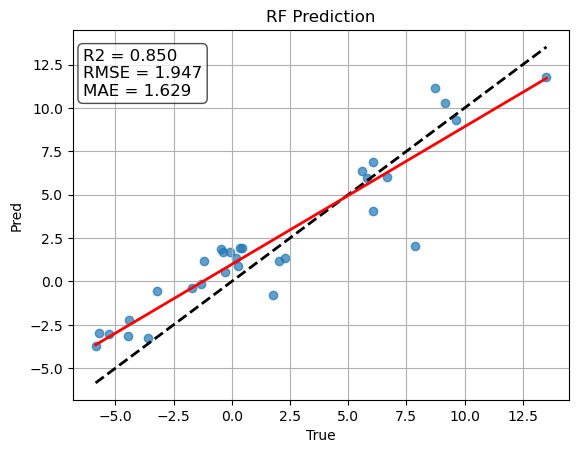

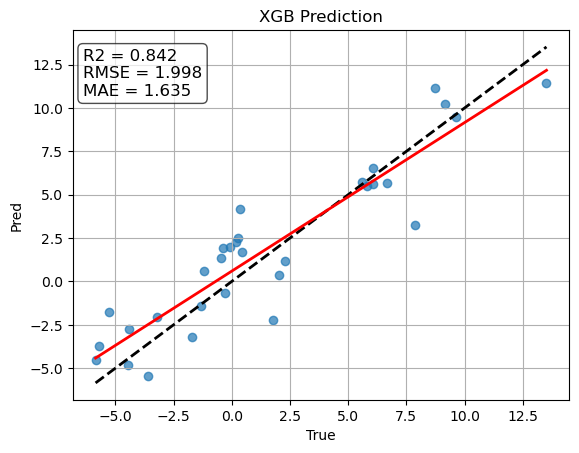

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 123, number of used features: 120
[LightGBM] [Info] Start training from score 2.174134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

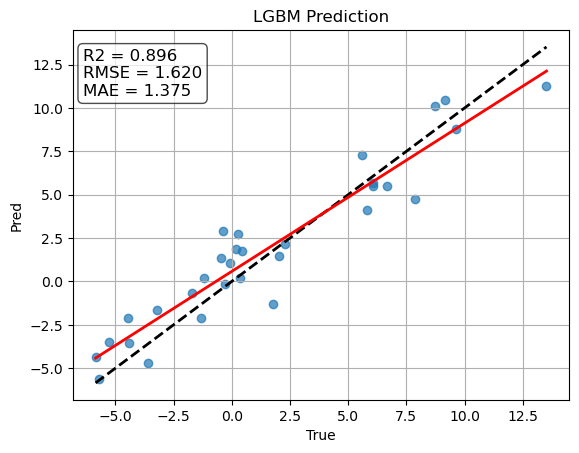

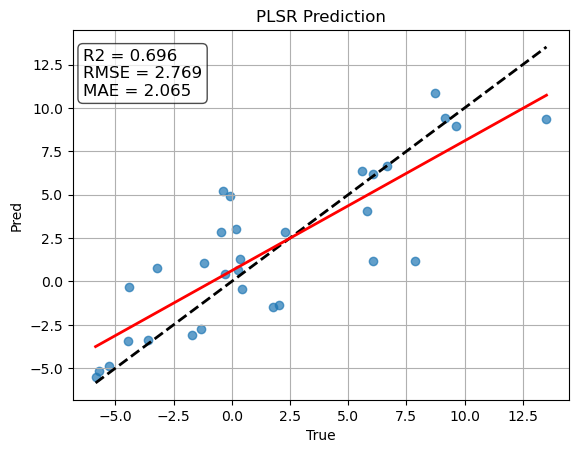

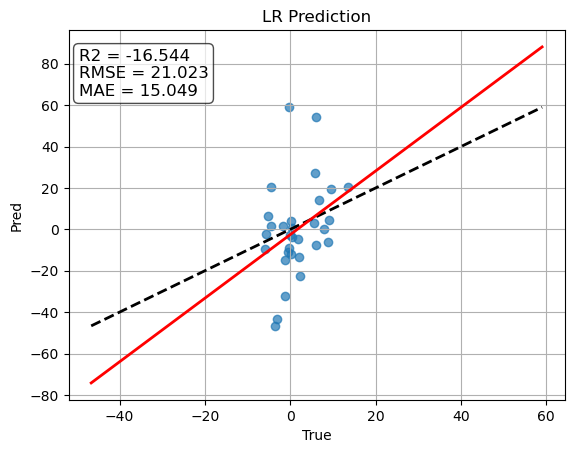


[ML Models Performance]
  model       rmse         r2        mae
0    rf   1.947140   0.849504   1.629214
1   xgb   1.997643   0.841596   1.635155
2  lgbm   1.619829   0.895847   1.374987
3  plsr   2.768728   0.695707   2.065070
4    lr  21.023377 -16.544324  15.049456


In [4]:
# ---- 머신러닝 모델 성능 평가 ----
ml_model_names = ['rf', 'xgb', 'lgbm', 'plsr', 'lr']
ml_results_df = ml_models_compare(X, y, models=ml_model_names, scaling='standard', plot=True)
print('\n[ML Models Performance]')
print(ml_results_df)


### 피쳐 갯수에 따른 성능 곡선 및 피쳐 중요도

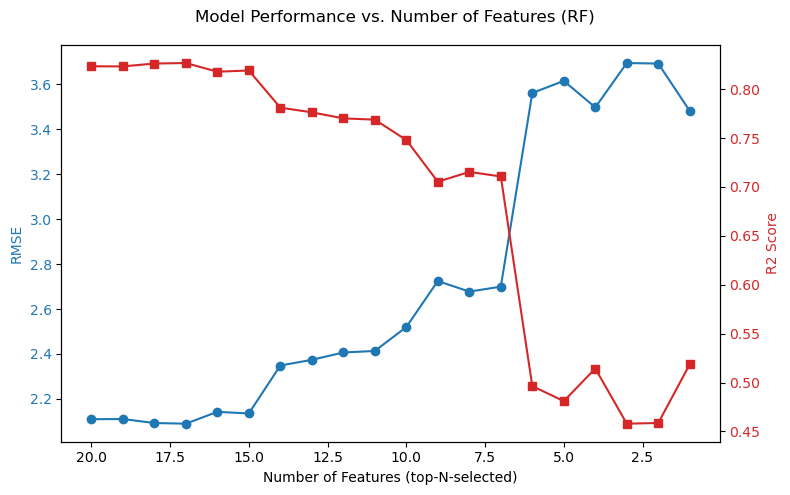

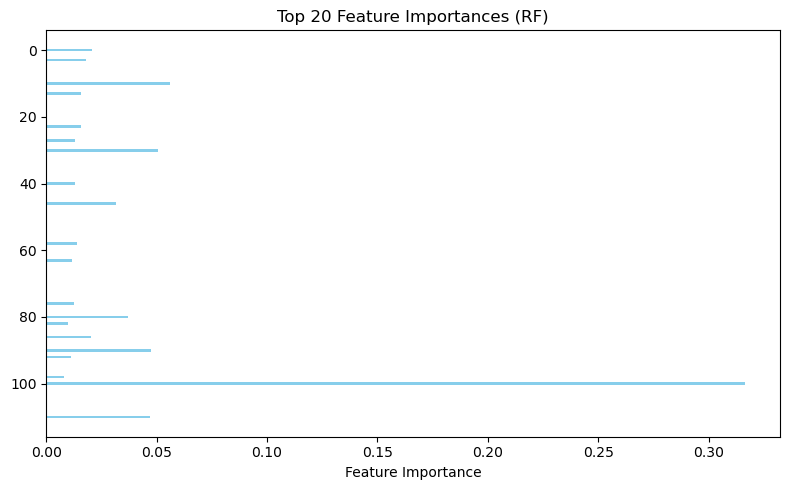

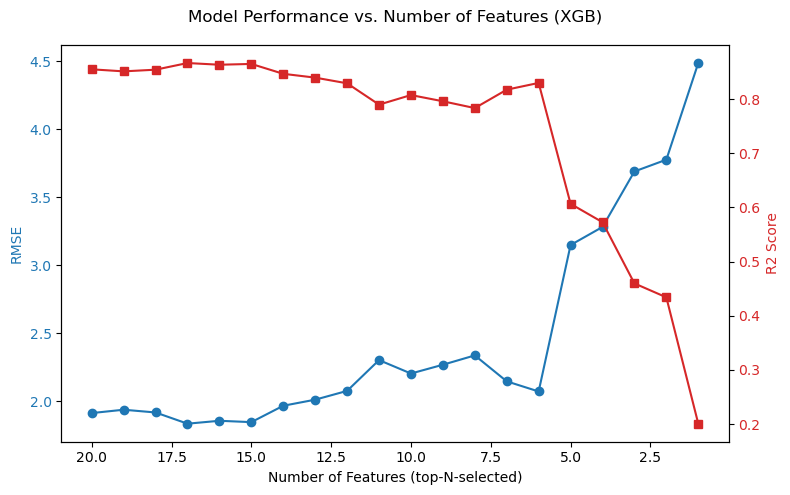

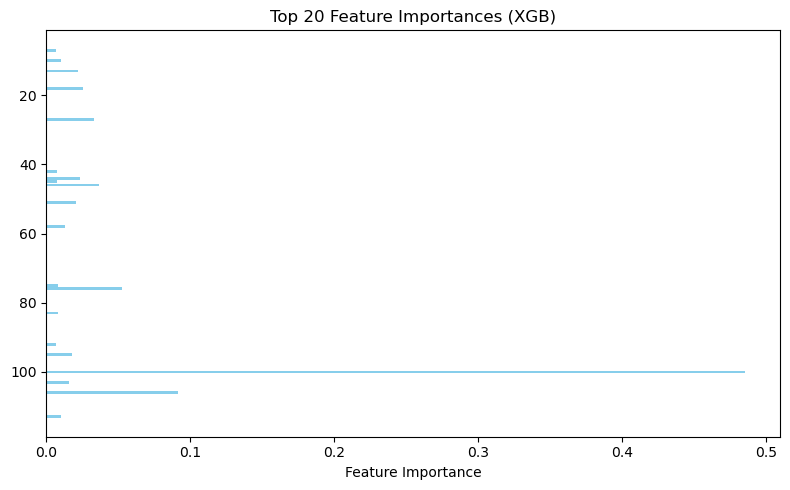

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 123, number of used features: 120
[LightGBM] [Info] Start training from score 2.174134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

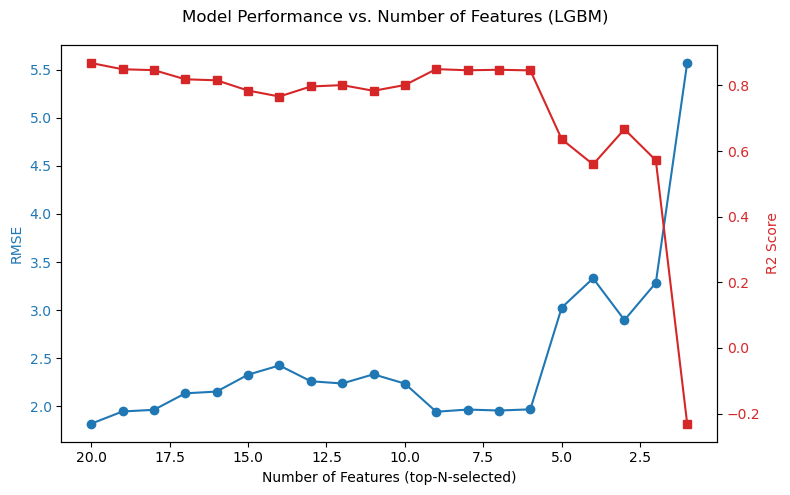

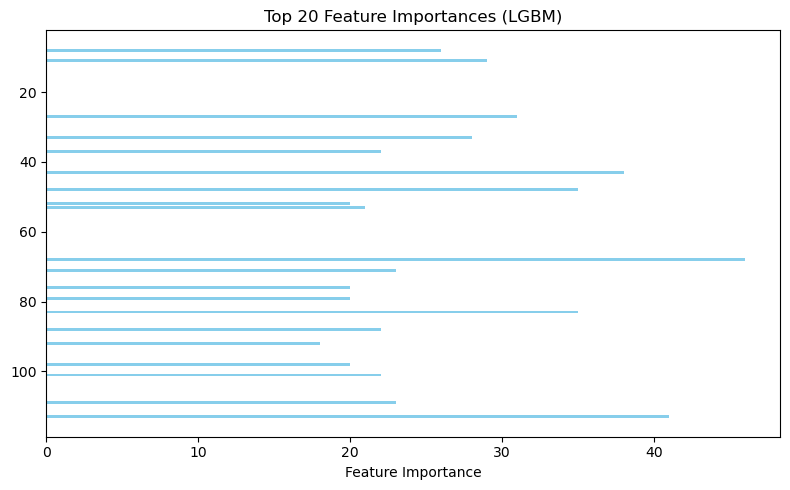

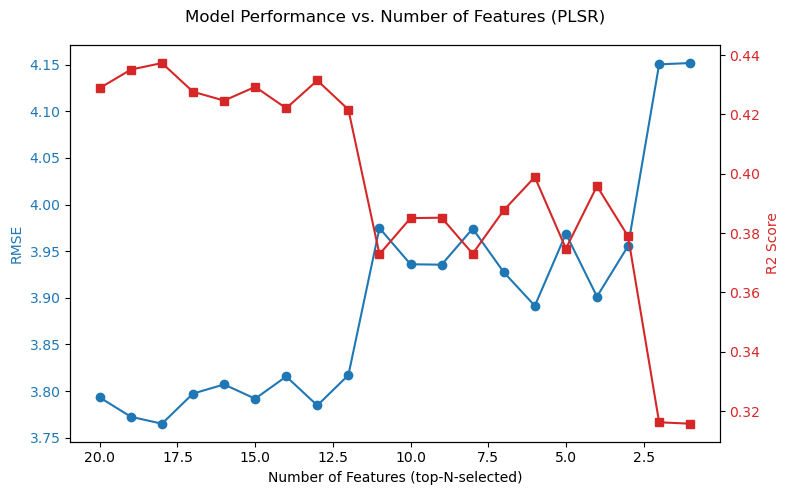

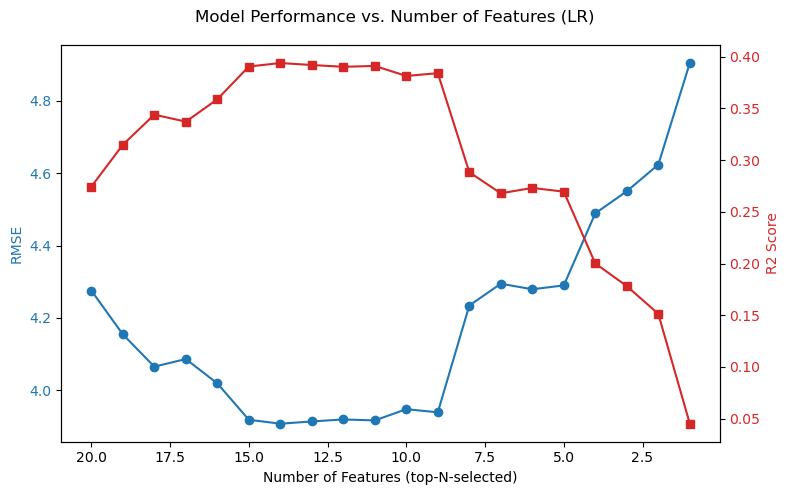

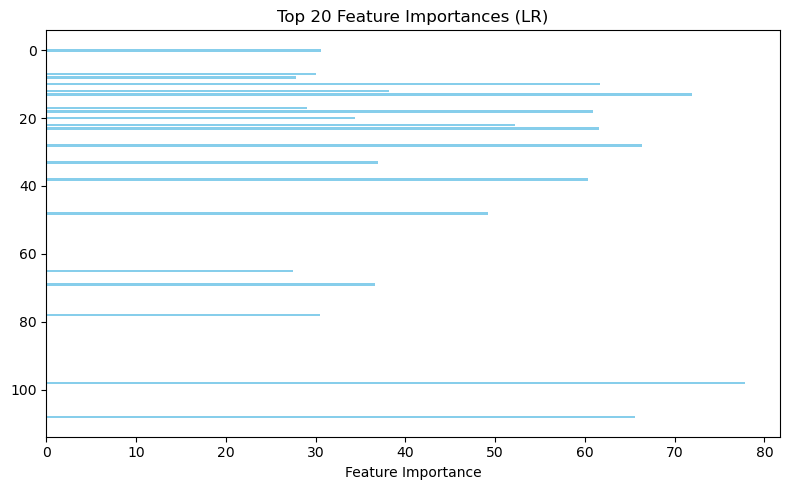

In [5]:
### 머신러닝 모델 성능 곡선 + 피쳐 중요도 ###
models= ['rf', 'xgb', 'lgbm', 'plsr', 'lr']
for model in models:
    result, feat_imp = ml_models_performance_curve(
        X, y, 
        model_type=model, 
        test_size=0.2, 
        random_state=42, 
        max_num_features=20, 
        plot=True,
        scaling='standard',
        model_params={}
    )

## 딥러닝 모델


== MLP ==


/home/cpark/anaconda3/envs/marketdb/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1753964091.915956   88993 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10078 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-07-31 21:14:53.219420: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fb238003980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-31 21:14:53.219436: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-07-31 21:14:53.239078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] dis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


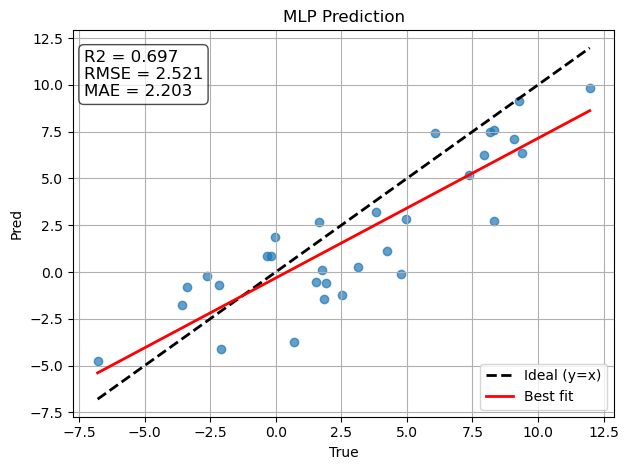


== CNN ==


/home/cpark/anaconda3/envs/marketdb/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


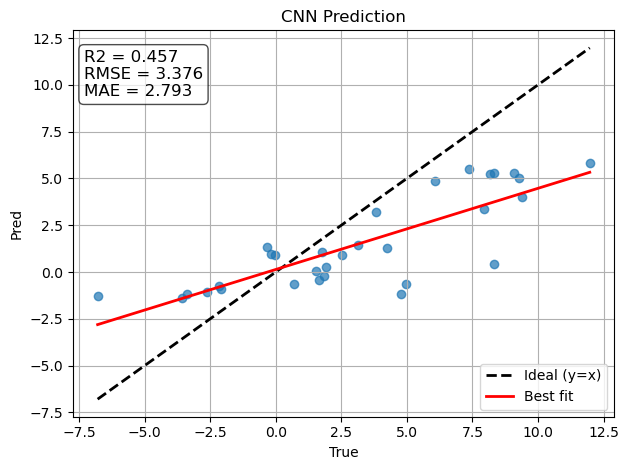


== LSTM ==


/home/cpark/anaconda3/envs/marketdb/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


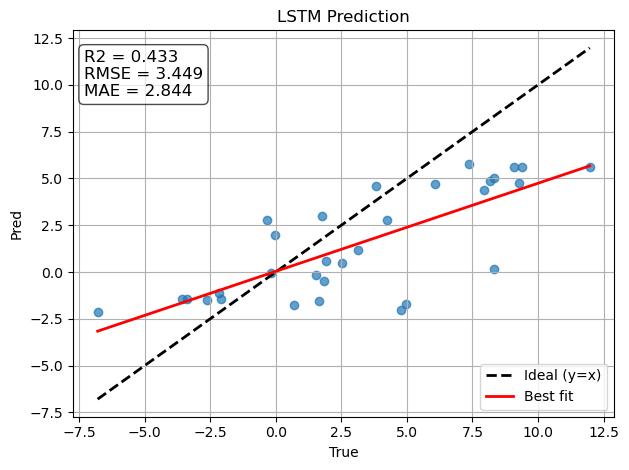


== GRU ==


/home/cpark/anaconda3/envs/marketdb/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


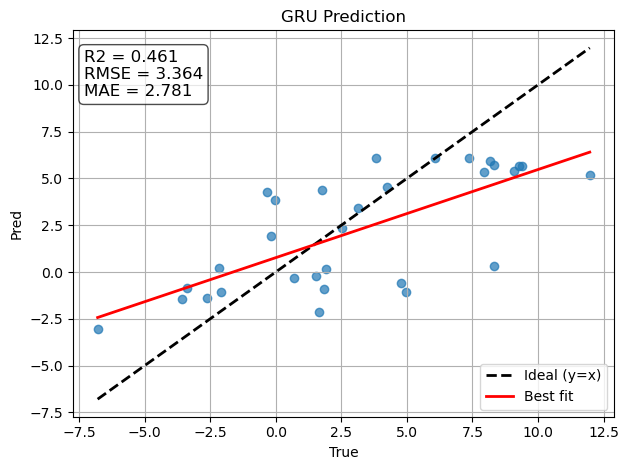


== CNN_LSTM ==


/home/cpark/anaconda3/envs/marketdb/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


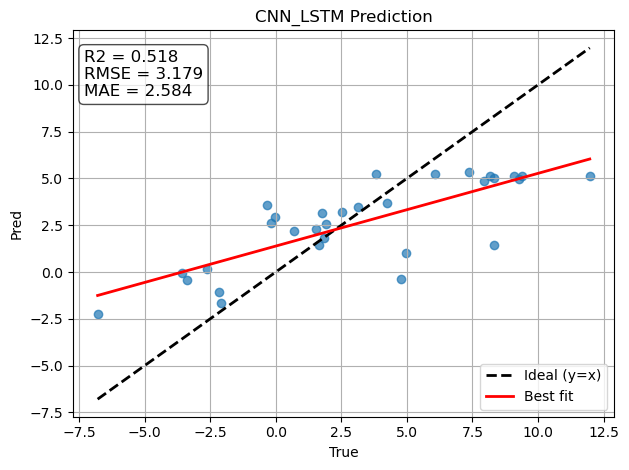


[DL Models Performance]
      model      rmse        r2
0       mlp  2.520588  0.697100
1       cnn  3.375686  0.456724
2      lstm  3.448721  0.432962
3       gru  3.363684  0.460581
4  cnn_lstm  3.179184  0.518133


In [6]:
# (4) 딥러닝용: sample별 전체 시계열 (shape: 샘플수, 시계열길이, feature수)
X_seq, y_seq = make_sequence_by_sample(x_df, y_df, sample_col='Sample_Number', time_col='time', feature_cols=my_features)

# ---- 딥러닝 모델 루프 ----
dl_model_names = ['mlp', 'cnn', 'lstm', 'gru', 'cnn_lstm']
dl_results = []
for mtype in dl_model_names:
    print(f"\n== {mtype.upper()} ==")
    _, rmse, r2 = dl_seq_train(
        X_seq, y_seq,
        model_type=mtype,
        n_units=32, epochs=20, scaling='standard',
        plot=True
    )
    dl_results.append({'model': mtype, 'rmse': rmse, 'r2': r2})
dl_results_df = pd.DataFrame(dl_results)
print('\n[DL Models Performance]')
print(dl_results_df)

## 최종 성능 비교

In [7]:
print('[ML Models Performance: by RMSE ascending]')
print(ml_results_df.sort_values('rmse', ascending=True).reset_index(drop=True))

print('\n[DL Models Performance: by RMSE ascending]')
print(dl_results_df.sort_values('rmse', ascending=True).reset_index(drop=True))

[ML Models Performance: by RMSE ascending]
  model       rmse         r2        mae
0  lgbm   1.619829   0.895847   1.374987
1    rf   1.947140   0.849504   1.629214
2   xgb   1.997643   0.841596   1.635155
3  plsr   2.768728   0.695707   2.065070
4    lr  21.023377 -16.544324  15.049456

[DL Models Performance: by RMSE ascending]
      model      rmse        r2
0       mlp  2.520588  0.697100
1  cnn_lstm  3.179184  0.518133
2       gru  3.363684  0.460581
3       cnn  3.375686  0.456724
4      lstm  3.448721  0.432962
